In [ ]:
!pip install -q scikit-learn opencv-python


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content
!unzip -q /content/chest-xray-pneumonia.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:20<00:01, 39.4MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s] 


In [ ]:
# Show folder structure & image counts
import os
from pathlib import Path

DATA_DIR = "/content/chest_xray"
TRAIN_DIR = f"{DATA_DIR}/train"
VAL_DIR   = f"{DATA_DIR}/val"
TEST_DIR  = f"{DATA_DIR}/test"

def count_files(p):
    exts = (".jpg",".jpeg",".png",".bmp")
    return sum(1 for f in Path(p).rglob("*") if f.suffix.lower() in exts)

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(d, "->", count_files(d), "images")

/content/chest_xray/train -> 5216 images
/content/chest_xray/val -> 16 images
/content/chest_xray/test -> 624 images


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH, seed=SEED
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)

CLASS_NAMES = train_ds.class_names  # e.g., ['NORMAL', 'PNEUMONIA']
print("Classes:", CLASS_NAMES)

# Cache + prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1024).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# Simple data augmentation
data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


Train label counts (index->count): Counter({1: 3875, 0: 1341})
Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mv2_pre

base = MobileNetV2(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet",
    pooling="avg",
    alpha=1.0
)
base.trainable = False  # warm-up

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = layers.Resizing(*IMG_SIZE)(inputs)
x = mv2_pre(x)
x = data_augment(x)
x = base(x, training=False)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # binary head

model = keras.Model(inputs, outputs, name="medvision_mobilenetv2")
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "medvision_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Warm-up (frozen base)
history1 = model.fit(
    train_ds, validation_data=val_ds, epochs=3,   # ↓ from 6
    class_weight=class_weight, callbacks=[ckpt, early], verbose=1
)

# Fine-tune the top of MobileNetV2
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)

history2 = model.fit(
    train_ds, validation_data=val_ds, epochs=4,   # ↓ from 8
    class_weight=class_weight, callbacks=[ckpt, early], verbose=1
)


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.8911 - auc: 0.9632 - loss: 0.2763
Epoch 1: val_auc improved from -inf to 0.98438, saving model to medvision_best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - acc: 0.8912 - auc: 0.9633 - loss: 0.2761 - val_acc: 0.7500 - val_auc: 0.9844 - val_loss: 0.3515
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9245 - auc: 0.9792 - loss: 0.1932
Epoch 2: val_auc did not improve from 0.98438
163/163 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - acc: 0.9245 - auc: 0.9792 - loss: 0.1931 - val_acc: 0.7500 - val_auc: 0.9844 - val_loss: 0.3990
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9324 - auc: 0.9821 - loss: 0.1755
Epoch 3: val_auc did not improve from 0.98438
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - acc: 0.9324 - auc: 0.9821 - loss: 0.1754 - val_acc: 0.7500 - val_auc: 0.9844 - val_loss: 0.3937
Epoch 1/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9123 - auc: 0.9742 - loss: 0.2084
Epoch 1: val_auc did not improv

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
import numpy as np

best = keras.models.load_model("medvision_best.keras")

y_true, y_prob = [], []
for X, y in test_ds:
    p = best.predict(X, verbose=0).ravel()
    y_prob.extend(p.tolist())
    y_true.extend(y.numpy().astype(int).tolist())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
auc = roc_auc_score(y_true, y_prob)

print(f"Test Acc: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Test Acc: 0.829 | Precision: 0.797 | Recall: 0.974 | F1: 0.877 | ROC-AUC: 0.951
Confusion Matrix:
 [[137  97]
 [ 10 380]]


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


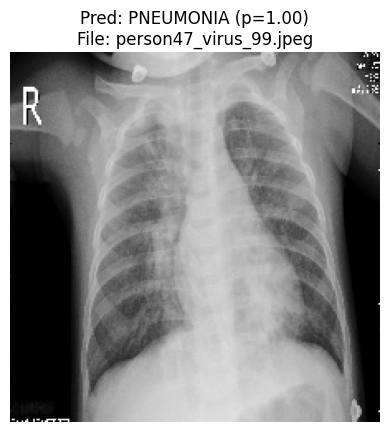

In [ ]:
import random, os
import matplotlib.pyplot as plt

def list_images(root):
    exts = (".jpg",".jpeg",".png",".bmp")
    out = []
    for cls in CLASS_NAMES:
        p = Path(root)/cls
        out += [str(f) for f in p.iterdir() if f.suffix.lower() in exts]
    return out

test_paths = list_images(TEST_DIR)
sample_path = random.choice(test_paths)

# Load + predict
img = tf.keras.preprocessing.image.load_img(sample_path, target_size=IMG_SIZE)
arr = tf.keras.preprocessing.image.img_to_array(img)[None, ...]
arr_pp = tf.keras.applications.mobilenet_v2.preprocess_input(arr)

prob = float(best.predict(arr_pp, verbose=0)[0][0])
pred_idx = 1 if prob >= 0.5 else 0
pred_name = CLASS_NAMES[pred_idx]

plt.imshow(img)
plt.axis("off")
plt.title(f"Pred: {pred_name} (p={prob:.2f})\nFile: {os.path.basename(sample_path)}")
plt.show()


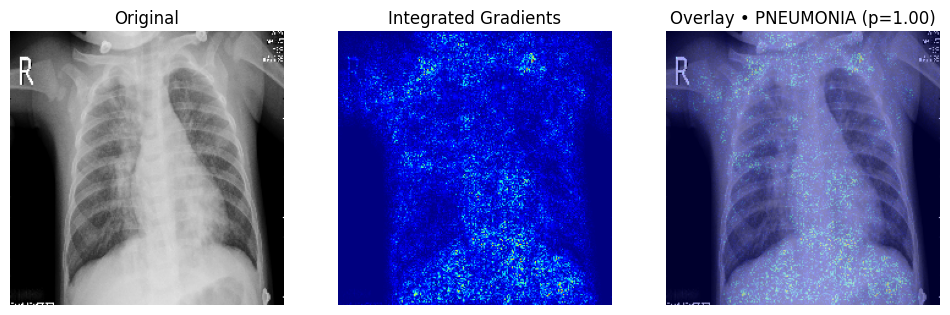

In [ ]:
# Added heatmap
import tensorflow as tf, numpy as np, cv2, matplotlib.pyplot as plt
from tensorflow import keras

IMG_SIZE = (224, 224)


target_model = model if 'model' in globals() else best


assert 'sample_path' in globals(), "Run the sample-prediction cell first to set sample_path."


from tensorflow.keras.preprocessing import image as kimage
img = kimage.load_img(sample_path, target_size=IMG_SIZE)
x = kimage.img_to_array(img)[None, ...].astype("float32")  # shape (1,H,W,3)

def integrated_gradients(m, inp, steps=32, baseline=None):
    # Baseline: black image (same shape) by default
    if baseline is None:
        baseline = tf.zeros_like(inp)
    # Linearly interpolate between baseline and input
    alphas = tf.linspace(0.0, 1.0, steps)[:, None, None, None]
    interpolated = baseline + alphas * (inp - baseline)           # (steps, H, W, 3)

    # Compute gradients wrt input along the path
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = m(interpolated, training=False)[:, 0]             # (steps,)
    grads = tape.gradient(preds, interpolated)                    # (steps, H, W, 3)

    # Average grads along the path
    avg_grads = tf.reduce_mean(grads, axis=0)                     # (H, W, 3)
    # Integrated gradients: (input - baseline) * avg_grads
    ig = (inp[0] - baseline[0]) * avg_grads                       # (H, W, 3)
    # Reduce to 2D heatmap
    heat = tf.reduce_sum(tf.abs(ig), axis=-1).numpy()             # (H, W)
    # Normalize 0..1
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    return heat

heat = integrated_gradients(target_model, tf.convert_to_tensor(x), steps=48)


heat_u8 = (heat * 255).astype(np.uint8)
heat_color = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(x[0].astype(np.uint8), 0.65, heat_color, 0.35, 0)


prob = float(target_model(tf.convert_to_tensor(x), training=False).numpy()[0,0])
pred_name = ["NORMAL","PNEUMONIA"][int(prob >= 0.5)]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x[0].astype(np.uint8)); plt.axis("off"); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(heat, cmap="jet"); plt.axis("off"); plt.title("Integrated Gradients")
plt.subplot(1,3,3); plt.imshow(overlay[..., ::-1]); plt.axis("off"); plt.title(f"Overlay • {pred_name} (p={prob:.2f})")
plt.show()
